## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться **прогнозировать отток клиентов**. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).


Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).


За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

* **contract_new.csv** — информация о договоре;

* **personal_new.csv** — персональные данные клиента;

* **internet_new.csv** — информация об интернет-услугах;

* **phone_new.csv** — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на **1 февраля 2020**.

## Исследовательский анализ данных

Импортируем все необходимые библиотеки для анализа:

In [ ]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import (train_test_split,
                                    RandomizedSearchCV,
                                    GridSearchCV,
                                    cross_val_score,
                                    StratifiedKFold)
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   RobustScaler)
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import time
from phik import phik_matrix
from sklearn.metrics import (roc_auc_score,
                             accuracy_score,
                             plot_confusion_matrix)

Подгрузим датасеты:

In [ ]:
#с помощью read_csv откроем датасеты и вложим их в переменные
try:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_phone = pd.read_csv('/datasets/phone_new.csv')
except:
    print('Ошбика загрузки датасетов.')

 ### Датасет с информацией о договоре

Посмотрим на наполнение:

In [ ]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


**Описание признаков:**

* customerID — ID абонента;
* BeginDate — дата начала действия договора;
* EndDate — дата окончания действия договора;
* Type — тип оплаты: раз в год-два или ежемесячно;
* PaperlessBilling — электронный расчётный лист;
* PaymentMethod — тип платежа;
* MonthlyCharges — расходы за месяц;
* TotalCharges — общие расходы абонента.

Посмотрим на общую информацию о датасете:

In [ ]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


* Явных пропусков не обнаружено;
* Тип данных столбца **TotalCharges** логично будет поменять на аналогичный у **MonthlyCharges**;
* Тип данных столбцов **BeginDate** и **EndDate** логично помнять на **datetime**.

In [ ]:
#df_contract = df_contract['TotalCharges'].astype('float64')

При попытке перевести данные к типу **float64** получили следующую ошибку: "*could not convert string to float: ' '*" - пропуски в столбце с общими расходами абонента.

Посмотрим на эти данные:

In [ ]:
display(df_contract[df_contract['TotalCharges'] == ' '])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Как мы можем заметить - общие расходы по нулям у тех клиентов, которые подключились **01.02.2020** - это дата также актуальности всего датасета, поэтому логично предположить, что в данном столбце значения будут равны совершенными расходами за месяц - **MonthlyCharges**.

**Поменяем все типы данных после соединения таблиц.**

Также проверим датасет на дубликаты:

In [ ]:
print('Количичество дубликатов:', df_contract.duplicated().sum())

Количичество дубликатов: 0


In [ ]:
display(df_contract.describe())

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Также оценим признак визуально:

Text(0, 0.5, 'Частота')

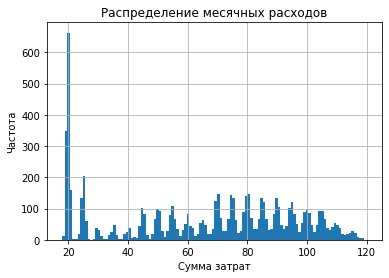

In [ ]:
df_contract.hist(bins = 120, range = (18, 120))
plt.title('Распределение месячных расходов')
plt.xlabel('Сумма затрат')
plt.ylabel('Частота')

Среднее **mean** по месячным затратам примерно 65 с разбросом от 18.25 до 118.75.
Ничего аномального подметить не удается - вполне нормальный разброс значений расходов у
пользователей подобных услуг.

По гистограмме распределения значений месячных затрат никаких аномалий также подметить не удается - вполне логично, что пользователей с наименьшим количеством затрат гораздо больше - скорее всего это стоимость базовых тарифов.

Основной ход просмотра информации о датасете ясен, поэтому для удобства напишем функцию, которая будет выводить все по одному запросу:

In [ ]:
def get_info(data):
        display(data.head())
        data.info()
        display(data.describe())
        print('Количество дубликатов:', data.duplicated().sum())


Визуализация распределения значений в каждом отдельном случае будет строиться, если потребуется.

### Датасет с персональными данными клиентов

Аналагично проверим датасет:

In [ ]:
get_info(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Количество дубликатов: 0


**Описание признаков**

* customerID — ID пользователя;
* gender — пол;
* SeniorCitizen — является ли абонент пенсионером;
* Partner — есть ли у абонента супруг или супруга;
* Dependents — есть ли у абонента дети.


Из примечательного можно отметить, что столбец **SeniorCitizen** мог бы иметь тип данных **bool**, так как явно **0** - польтзователь не является пенсионером, а **1** - является.
Оставим пока что этот стобец без изменений для упрощения работы при обучении моделей.

### Датасет с информацией об интернет-услугах

In [ ]:
get_info(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,4832-VRBMR,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество дубликатов: 0


**Описание признаков:**

* customerID — ID пользователя;
* InternetService — тип подключения;
* OnlineSecurity — блокировка опасных сайтов;
* OnlineBackup — облачное хранилище файлов для резервного копирования данных;
* DeviceProtection — антивирус;
* TechSupport — выделенная линия технической поддержки;
* StreamingTV — стриминговое телевидение;
* StreamingMovies — каталог фильмов.

### Датасет с информацией об услухаг телефонии

In [ ]:
get_info(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,4832-VRBMR,No
freq,1,3390


Количество дубликатов: 0


**Описание признаков:**

* customerID — ID пользователя;
* MultipleLines — подключение телефона к нескольким линиям одновременно.

## Вывод

На этапе исследовательского анализа данных мы загрузили и изучили 4 датасета, информация о которых представлена выше.

По итогам нашего исследования общая картина следующая:

* **df_contract** и **df_personal** имеют в себе полное наполнение по записям, так как у них одинаковое число объектов - **7043**;
* **df_internet** имеет в себе **5517** объектов - из чего можно сделать вывод о том, что датасет не наполняется информацией о пользователях, которые не имеют подключенные интернет услуги;
* **df_phone** имеет в себе **6361** объектов - скорее всего не все пользователи подключили телефонию;
* в каждом представленом датасете пропусков и дубликатов не обнаружено.

Из нюансов можно отметить следующее:

* столбец **TotalCharges** имеет неявные пропуски по тем пользователям, которые были подключены **01.02.2020**, вследствие чего столбец имеет некорректный тип данных;
* столбцы с датой подключения и окончательной датой использования имеют некорректный тип данных;



## Предобработка данных

### Соединение таблиц

В рамках установленного плана работы, в первую очередь, соединим все таблицы в один датасет. Объединять будем по столбцу **customer_id**.

In [ ]:
df = (df_contract.merge(df_personal, on = ['customerID'], how = 'inner')
      .merge(df_internet, on = ['customerID'], how = 'left')
      .merge(df_phone, on = ['customerID'], how = 'left'))

Проверим размерность датасета:

In [ ]:
df.shape

(7043, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Никакие данные не потерялись - мы получили **7043** записи из полных датасетов как изначально и было, а также 19 признаков. **customerID** за признак не считаем.

### Приведение к нижнему регистру

Далее переведем названия столбцов к нижнему регистру:

In [ ]:
df.columns = [x.lower() for x in df.columns]

### Приведение к змеиному регистру

Теперь перведем отдельные столбцы к змеиному регистру:

In [ ]:
df.rename(columns = {'customerid' : 'customer_id',
                    'begindate' : 'begin_date',
                    'enddate' : 'end_date',
                    'paperlessbilling' : 'paperless_billing',
                     'paymentmethod' : 'payment_method',
                    'monthlycharges' : 'monthly_charges',
                    'totalcharges' : 'total_charges',
                    'seniorcitizen' : 'senior_citizen',
                    'internetservice' : 'internet_service',
                    'onlinesecurity' : 'online_security',
                    'onlinebackup' : 'online_backup',
                    'deviceprotection' : 'device_protection',
                    'techsupport' : 'tech_support',
                    'streamingtv' : 'streaming_tv',
                    'streamingmovies' : 'streaming_movies',
                    'multiplelines' : 'multiple_lines'}, inplace = True)

In [ ]:
#проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

### Изменение типов данных

Для начала выделим целевой признак:

In [ ]:
df['abandoned'] = np.where(df['end_date'] == 'No', 0, 1)

In [ ]:
#проверяем
df['abandoned'].value_counts()

0    5942
1    1101
Name: abandoned, dtype: int64

#### **total_charges**

Разберемся с данными в столбце **total_charges**:

In [ ]:
df.loc[df['total_charges'] == ' ', 'total_charges'] = df.loc[df['total_charges'] == ' ', 'monthly_charges']

Успехом в данной операции может сигнализировать приведение значений столбца к типу **float64**:

In [ ]:
df['total_charges'] = df['total_charges'].astype('float64')

In [ ]:
#проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

#### begin_date

Преобразуем тип данных столбца **begin_date** к типу **datetime**:

In [ ]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format = '%Y-%m-%d')

#### end_date

Также преобразуем тип данных столбца **end_date**. Но прежде мы предобратаем записи в столбцы равные **No**.
Эти значения поменяем на дату актуальности датасета:

In [ ]:
#меняем значения
df.loc[df['end_date'] == 'No', 'end_date'] = '2020-02-01'
#меняем тип данных
df['end_date'] = pd.to_datetime(df['end_date'], format = '%Y-%m-%d')

In [ ]:
#проверяем
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,abandoned
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


In [ ]:
df['end_date'].value_counts()

2020-02-01    5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-12-01       2
2015-04-01       2
2014-06-01       1
2014-11-01       1
2014-10-01       1
Name: end_date, Length: 67, dtype: int64

In [ ]:
#проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [ ]:
df['senior_citizen'] = df['senior_citizen'].astype('object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

### Создание новых признаков

#### Длительность договора

Теперь создадим новый признак, который будет хранить в себе длительность действия абонентского договора в днях:

In [ ]:
#df_end_date = pd.to_datetime('2020-02-01')
df['duration'] = (df['end_date'] - df['begin_date']).dt.days

In [ ]:
#проверяем
df['duration'].value_counts()

2191    265
153     249
92      243
31      236
123     236
       ... 
121       1
2253      1
424       1
1309      1
547       1
Name: duration, Length: 251, dtype: int64

In [ ]:
#проверяем
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,abandoned,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,NaN,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


Для наглядности выведем информацию, чтобы оценить ситуацию с новообразовавшимися пропусками:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

Как уже было отмечено ранее, пропуски образовались в результате отсутсвия данных, а отсутсвуют они логично по причине того, что клиент не подключил доп.услуги, поэтому просто заполним этими пропуски:

In [ ]:
internet_cols = ['internet_service',
                 'online_security',
                 'online_backup',
                 'device_protection',
                 'tech_support',
                 'streaming_tv',
                 'streaming_movies']


df[internet_cols] = df[internet_cols].fillna('No_Internet')

df['multiple_lines'] = df['multiple_lines'].fillna('No_Phone')

In [ ]:
#проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

Создадим также признак, который будет содержать в себе информацию, пользовался ли клиент услугами интернета.
1 - если в любом столбце, причастному к интернет-услугам будет иметься положительная информация, 0 - напротив:

In [ ]:
df['internet_connected'] = 1
df.loc[df[internet_cols].apply(lambda x: (x != 'No_Internet').any(), axis = 1), 'internet_connected'] = 0

In [ ]:
df['internet_connected'].value_counts()

0    5517
1    1526
Name: internet_connected, dtype: int64

Поменяем также тип на **object**:

In [ ]:
df['internet_connected'] = df['internet_connected'].astype('object')

### Проверка мультиколлинеарности

Теперь проверим количественные данные на мультиколлениарность, чтобы избежать ошибок при обучении модели и избежать ее переобучения:

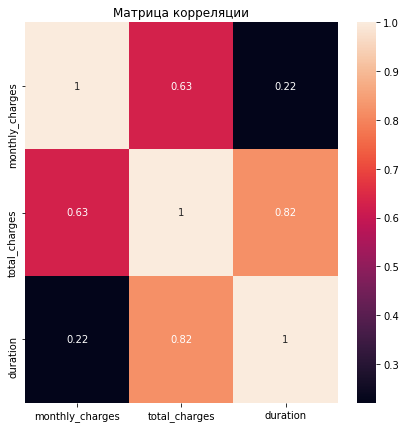

In [ ]:
num = ['monthly_charges', 'total_charges', 'duration']

plt.figure(figsize = (7, 7))
plt.title('Матрица корреляции')

sns.heatmap(df[num].corr(), annot = True)
plt.show()

Столбец **total_charges** мультиколлинеарный по отношению к **duration** - чем больше дней клиент пользуется, тем больше общих расходов.

Столбец этот мы удалим.

Построим матрицу корреляции по всем признакам:

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'duration']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable customer_id is large: 7043. Are you sure this is not an interval variable? Analysis for pairs of variables including customer_id can be slow.
  warnings.warn(


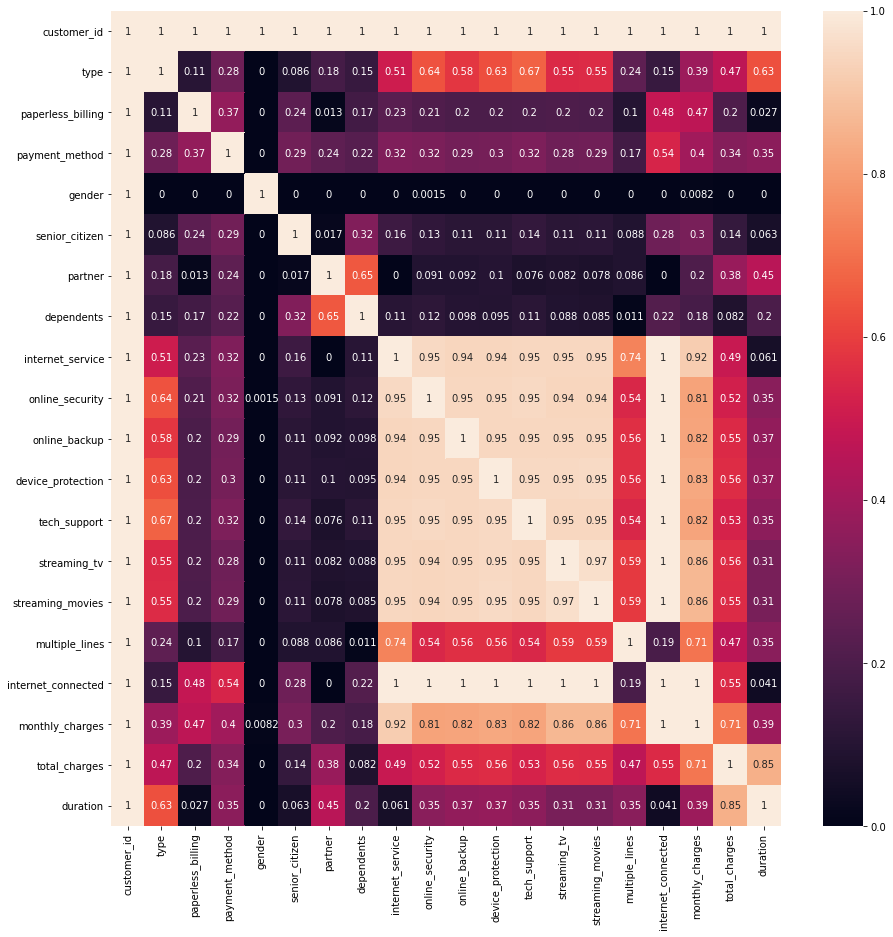

In [ ]:
cats = df.select_dtypes(include = ['object']).columns.tolist()

phik_cat = df[cats]
phik_num = df[num]

phik_df = pd.concat([phik_cat.reset_index(drop = True),
                     phik_num.reset_index(drop = True)],
                    axis = 1)
corr_matrix = phik_matrix(phik_df)

plt.figure(figsize = (15, 15))
sns.heatmap(corr_matrix, annot = True)
plt.show()

Заметна мультиколлинерность:

1. **total_charges**, о котором уже было сказано - он под удаление
2. **monthly_charges** также придется удалить
3. **internet_service** под удаление


### Удаление избыточных признаков

Удаляем столбец **total_charges**:

In [ ]:
df.drop(['total_charges'], axis = 1, inplace = True)

Так как у нас есть признак с длительностью пользования клиентом услуг компании, то признаки с датой начала и датой окончания пользования услугами будут также избыточными:


In [ ]:
df.drop(['begin_date'], axis = 1, inplace = True)
df.drop(['end_date'], axis = 1, inplace = True)

**gender** вообще ни на что не влияющий параметр - его тоже удаляем, чтобы не засорять выборки:

In [ ]:
df.drop(['gender'], axis = 1, inplace = True)

Удаляем **monthly_charges**:

In [ ]:
df.drop(['monthly_charges'], axis = 1, inplace = True)

Удаляем **internet_service**:

In [ ]:
df.drop(['internet_service'], axis = 1, inplace = True)

In [ ]:
#проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         7043 non-null   object
 1   type                7043 non-null   object
 2   paperless_billing   7043 non-null   object
 3   payment_method      7043 non-null   object
 4   senior_citizen      7043 non-null   object
 5   partner             7043 non-null   object
 6   dependents          7043 non-null   object
 7   online_security     7043 non-null   object
 8   online_backup       7043 non-null   object
 9   device_protection   7043 non-null   object
 10  tech_support        7043 non-null   object
 11  streaming_tv        7043 non-null   object
 12  streaming_movies    7043 non-null   object
 13  multiple_lines      7043 non-null   object
 14  abandoned           7043 non-null   int64 
 15  duration            7043 non-null   int64 
 16  internet_connected  7043

И также избавляемся от **customer_id**:

In [ ]:
df.drop(['customer_id'], axis = 1, inplace = True)

Данные полностью исследованы и предобработаны:

* мы изменили тип данных в столбце **total_charges**, заполнив пропуски у совсем свеженьких клиентов на показатели из столбца **monthly_charges**;
* мы измениили тип данных в столбце **end_date**, предварительно избавившись от лишних записей - наглядно показав, что информации достаточной у нас не имеется;
* мы изменили тип данных в столбце **begin_date**
* избавились от пропусков, образовавшихся в результате слияние таблиц;
* создали новый признак длительности договора - теперь у нас есть столбец с количеством дней пользования клиентом услуг компании - **duration**;
* создали новый признак - целевой - **abandoned**, который показывает ушел клиент из компании или нет;
* из финального датасета убрали избыточные признаки.

### Разделение выборки

In [ ]:
#выделяем признаки и целевой признак
features = df.drop(['abandoned'], axis = 1)
target = df['abandoned']

In [ ]:
#размер тестовой выборки задан тимлидом - 0.25, random_state = 310723
f_train, f_test, t_train, t_test = train_test_split(
    features,
    target,
    test_size = 0.25,
    random_state = 310723,
    stratify = target
)

In [ ]:
print('Обучающая выборка:', f_train.shape,
     t_train.shape)
print('Тестовая выборка:', f_test.shape,
     t_test.shape)

Обучающая выборка: (5282, 15) (5282,)
Тестовая выборка: (1761, 15) (1761,)


### Кодирование признаков

Проведем кодирование категориальных признаков с помощью **OHE** для модели логистической регрессии:

In [ ]:
#выделяем категориальные признаки
cat_columns = df.select_dtypes(include = ['object']).columns.tolist()
#выделяем количественные признаки
num_columns = df.select_dtypes(include = ['int64']).drop(columns = ['abandoned']).columns.tolist()

In [ ]:
#создаем объект OneHotEncoder
ohe = OneHotEncoder(handle_unknown = 'error', drop = 'first')
#обучаем и кодируем кодировщик на тренировочной выборке и сразу создаем датафрейм
f_train_ohe = pd.DataFrame(ohe.fit_transform(f_train[cat_columns]).toarray(),
                           columns=ohe.get_feature_names(cat_columns))
f_train_encoded = pd.concat([f_train_ohe, f_train[num_columns].reset_index(drop = True)], axis = 1)

#кодируем тестовую выборку и сразу создаем датафрейм
f_test_ohe = pd.DataFrame(ohe.transform(f_test[cat_columns]).toarray(),
                          columns=ohe.get_feature_names(cat_columns))
f_test_encoded = pd.concat([f_test_ohe, f_test[num_columns].reset_index(drop = True)], axis = 1)

In [ ]:
#проверяем
f_train_encoded.head()

,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,senior_citizen_1,partner_Yes,dependents_Yes,online_security_No_Internet,...,tech_support_No_Internet,tech_support_Yes,streaming_tv_No_Internet,streaming_tv_Yes,streaming_movies_No_Internet,streaming_movies_Yes,multiple_lines_No_Phone,multiple_lines_Yes,internet_connected_1,duration
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,273
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1340
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,215
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,488
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1248


In [ ]:
f_test_encoded.shape

(1761, 25)

In [ ]:
#проверяем
f_train_encoded.shape

(5282, 25)

Данные закодированы, теперь приступаем к моделированию!

## Моделирование

Обучать мы будем три модели:

1. Логистическая регрессия
2. Случайный лес
3. CatBoost

Также создадим объект StratifiedKFold для проведения стратифицированной кросс-валидации:

In [ ]:
CV = StratifiedKFold(shuffle = True,
                    random_state = 310723)

### Логистическая регрессия

Прежде всего масштабируем количественные признаки:

In [ ]:
#создаем объект StandardScaler
#scaler = StandardScaler()
#обучаем и масштабируем тренировочную выборку
#f_train_scaler = pd.DataFrame(scaler.fit_transform(f_train_encoded[num_columns]),
#                              columns = num_columns)
#масштабируем тестовую
#f_test_scaler = pd.DataFrame(scaler.transform(f_test_encoded[num_columns]),
#                             columns = num_columns)
#объединяем масштабированные признаки с закодированными категориальными
#f_train_scaled = pd.concat([f_train_scaler,
#                           f_train_encoded.drop(num_columns, axis = 1).reset_index(drop=True)],
#                          axis = 1)
#f_test_scaled = pd.concat([f_test_scaler,
#                           f_test_encoded.drop(num_columns, axis =1).reset_index(drop=True)],
#                          axis = 1)

In [ ]:
#проверяем
#f_train_scaled.head()

In [ ]:
#проверяем
#f_train_scaled.shape

Подберем гиперпараметры модели логистичесой регрессии и обучим ее:

In [ ]:
#создаем объект LogisticRegression, random_state задан тимлидом
model = LogisticRegression(random_state = 310723,
                          class_weight = 'balanced')
#создадим словарь для перебора значений регуляризации
param_grid = {'C' : [0.001, 0.01, 0.1, 1.0],
             'penalty' : ['l1', 'l2'],
             'solver' : ['lbfgs',
                        'newton-cg',
                        'sag',
                        'saga',
                        'liblinear']}
#с помощью GridSearchCV подберем лучшее значение C
grid_search_log_reg = GridSearchCV(estimator = model,
                                param_grid = param_grid,
                                cv = CV,
                                scoring = 'roc_auc',
                                verbose = 0)
start = time.time()
grid_search_log_reg.fit(f_train_encoded, t_train)
end = time.time() - start
best_param_log_reg = grid_search_log_reg.best_params_
print('Лучшее значение C:', best_param_log_reg)
print('Время поиска лучшего значения:', end, 'секунд')

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: Fi

Лучшее значение C: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Время поиска лучшего значения: 84.63152146339417 секунд


model_log_reg = LogisticRegression(C = 0.1,
                                   random_state = 310723,
                                   solver = 'liblinear',
                                   class_weight = 'balanced')
roc_auc_log_reg = cross_val_score(model_log_reg,
                                f_train_scaled,
                                t_train,
                                cv = 5,
                                scoring = 'roc_auc').mean()
print('ROC-AUC для Логистической регрессии:', roc_auc_log_reg)

In [ ]:
print('ROC-AUC для Логистической регрессии:', grid_search_log_reg.best_score_)

ROC-AUC для Логистической регрессии: 0.766480061008475


### Случайный лес

Также с помощью GridSearchCV подберем значения
* **n_estimators** - количество деревьев
* **max_depth** - максимальная глубина каждого дерева
* **min_samples_split** - минимальное количество образцов для разделения узла
* **min_samples_leaf** - минимальное количество наблюдений в листе дерева

In [ ]:
#создаем словарь с параметрами
param_grid = {'n_estimators' : [300], #при измнении шагов, мне всегда выдавал лучшим этот показатель, поэтому для ускорения поиска оставлю его сразу
             'max_depth': [2, 5, 8],
             'min_samples_split' : [1, 4, 7],
             'min_samples_leaf' : [1, 4, 7]}
#создаем объект случайного леса
model = RandomForestClassifier(random_state = 310723,
                          class_weight = 'balanced')
#с помощью GridSearchCV подберем лучшие параметры
grid_search_rf = GridSearchCV(estimator = model,
                          param_grid = param_grid,
                          cv = CV,
                          scoring = 'roc_auc',
                          n_jobs = -1,
                          verbose = 0)
start = time.time()
grid_search_rf.fit(f_train_encoded,
                   t_train)
end = time.time() - start
best_params_rf = grid_search_rf.best_params_
print('Лучшие значения гиперпараметров:', best_params_rf)
print('Время поиска лучших значений:', end, 'секунд')

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

Лучшие значения гиперпараметров: {'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 300}
Время поиска лучших значений: 71.10768175125122 секунд


Теперь оценим производительность модели с лучшими гиперпараметрами на метрике ROC-AUC:

In [ ]:
print('ROC-AUC для Случайного леса:', grid_search_rf.best_score_)

ROC-AUC для Случайного леса: 0.8303906461456542


### CatBoost

Также с помощью GridSearchCV подберем значения
* **iterations** - количество итераций
* **learning_reate** - шаг градиентного спуска
* **depth** - максимальная глуина дерева
* **l2_leaf_reg** - коэффициент L2-регуляризации

Гиперпараметру **loss_function** мы передадим значение **Logloss**, так как у нас имеется параметр **auto_class_weights** равный **Balanced**, а также гиперпараметру **eval_metric** передадим значение **AUC**.

In [ ]:
param_grid = {'iterations' : [400, 450, 500],
             'learning_rate' :  [0.1, 0.3, 0.5],
             'depth' : [3, 6, 9],
             'l2_leaf_reg' : [1, 3, 5],
             'eval_metric' : ['AUC'],
             'loss_function' : ['Logloss']}
model = CatBoostClassifier(random_state = 310723,
                           silent = True,
                           auto_class_weights = 'Balanced')
grid_search_cb = GridSearchCV(estimator = model,
                          param_grid = param_grid,
                          cv = 5,
                          verbose = 2,
                          scoring = 'roc_auc')
start = time.time()
grid_search_cb.fit(f_train,
                   t_train,
                   cat_features = cat_columns)
end = time.time() - start

best_params_cb = grid_search_cb.best_params_
print('Лучшие значения гиперпараметров:', best_params_cb)
print('Время поиска лучших значений:', end, 'секунд')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END depth=3, eval_metric=AUC, iterations=400, l2_leaf_reg=1, learning_rate=0.1, loss_function=Logloss; total time=   3.1s
[CV] END depth=3, eval_metric=AUC, iterations=400, l2_leaf_reg=1, learning_rate=0.1, loss_function=Logloss; total time=   3.0s
[CV] END depth=3, eval_metric=AUC, iterations=400, l2_leaf_reg=1, learning_rate=0.1, loss_function=Logloss; total time=   3.2s
[CV] END depth=3, eval_metric=AUC, iterations=400, l2_leaf_reg=1, learning_rate=0.1, loss_function=Logloss; total time=   3.0s
[CV] END depth=3, eval_metric=AUC, iterations=400, l2_leaf_reg=1, learning_rate=0.1, loss_function=Logloss; total time=   2.9s
[CV] END depth=3, eval_metric=AUC, iterations=400, l2_leaf_reg=1, learning_rate=0.3, loss_function=Logloss; total time=   3.1s
[CV] END depth=3, eval_metric=AUC, iterations=400, l2_leaf_reg=1, learning_rate=0.3, loss_function=Logloss; total time=   3.1s
[CV] END depth=3, eval_metric=AUC, iterations=400

In [ ]:
print('ROC-AUC для CatBoost:', grid_search_cb.best_score_)

ROC-AUC для CatBoost: 0.9236659754132909


Сохраним лучшие гиперпараметры:
{'depth': 3,

'eval_metric': 'AUC',

'iterations': 500,

'l2_leaf_reg': 1,

'learning_rate': 0.3,

'loss_function': 'Logloss'}

После перебора гиперпараметров и обучения моделей - наилучшим образом себя показал CatBoost. Следовательно, проверим модель на тестовой выборке.

## Проверка модели на тестовой выборке

Проверим ROC-AUC на тесте:

In [ ]:
roc_auc_cb = roc_auc_score(t_test,
                          grid_search_cb.predict_proba(f_test)[:, 1])
print('ROC-AUC для CatBoost на тестовой выборке:', roc_auc_cb)

ROC-AUC для CatBoost на тестовой выборке: 0.9315233084546678


Проверим точность на тестовой выборке:

In [ ]:
acc_cb = accuracy_score(t_test,
                       grid_search_cb.predict(f_test))
print('Accuracy для CatBoost:', acc_cb)

Accuracy для CatBoost: 0.8983532084043158


Построим матрицу ошибок:

In [ ]:
from sklearn.metrics import plot_confusion_matrix, classification_report

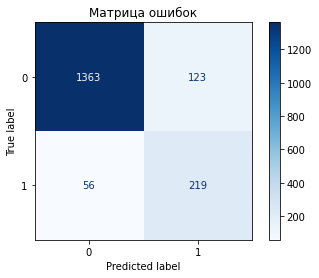

In [ ]:
plot_confusion_matrix(grid_search_cb.best_estimator_,
                     f_test,
                     t_test,
                     cmap = plt.cm.Blues)
plt.title('Матрица ошибок')
plt.show()

Модель продемонстрировала хорошую способность правильно классифицировать оставшихся клиентов.

Построим на распределение важности признаков:

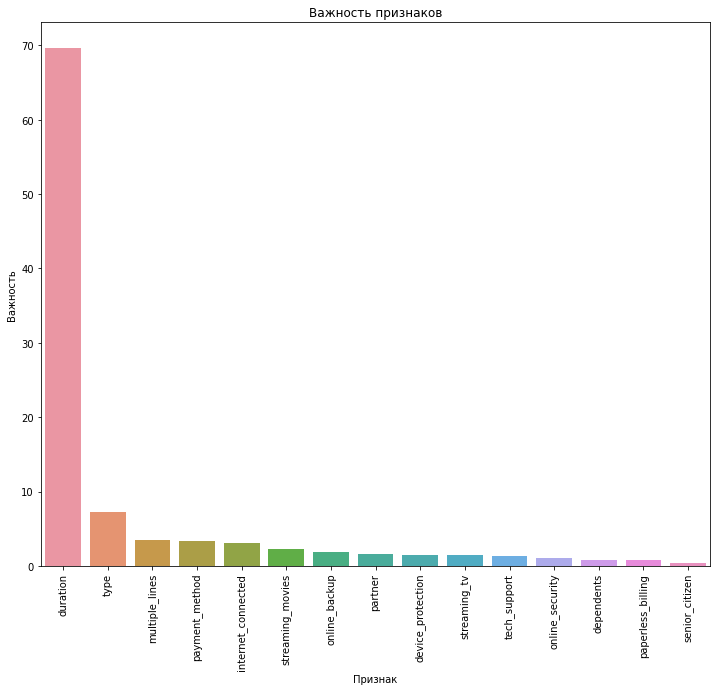

In [ ]:
f_importance = pd.DataFrame(data = {
    'Feature' : f_train.columns,
    'Importance' : grid_search_cb.best_estimator_.get_feature_importance()
})

f_importance = f_importance.sort_values(by = 'Importance',
                                       ascending = False)
plt.figure(figsize = (12, 10))
sns.barplot(x = f_importance['Feature'], y = f_importance['Importance'])
plt.xticks(rotation = 'vertical')
plt.title('Важность признаков')
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.show()

Самым важным признаком оказался **duration**, который содержал в себе количество дней пользования услугами.

## Выводы

В ходе исследования моделей машинного обучения, а именно:
* **Логистическая регрессия**;
* **Случайный лес**;
* **CatBoost**
лучше всех себя показал **CatBoost** с **ROC-AUC** на тесте равным **0.93**, что удовлетворяет условиям поставленной перед нами задачи тимлидом, а также **Accuracy** равным **0.89**, что означаетЮ что наша модель примерно 9 раз из 10 верно предсказала уход клиента или его продолжение его сотрудничества с телеком-компанией.

Для каждой модели мы тщательно и очень много раз подбирали гиперпараметры с помощью **GridSearchCV**, и такие хорошие результаты **CatBoost** показал при:
* **depth** = 3,
* **eval_metric** = AUC
* **iterations** = 500
* **l2_leaf_reg** = 1
* **learning_rate** = 0.3
* **loss_function** = Logloss

Для правильного обучения моделей мы изучили 4 стартовых датасета, затем объединили его в один общий, данные в котором мы предобработали:
* избавились от образовавшихся пропусков;
* изменили типы данных;
* создали несколько признаков;
* удалили избыточные признаки;
* проверили признаки на мультиколлинеарность и избавились от подобных;
* а также закодировали категориальные признаки.

В результате всей нашей работы по анализу данных и машинному обучению мы можем утверждать, что модель **CatBoost** можно использовать для задачи классификации клиентов, которые могут покинуть компанию, и во время начать процесс удержания клиентов.

## Отчет

В ходе данного исследования мы провели анализ и выбор модели машинного обучения для решения задачи классификации клиентов, которые могут покинуть компанию. Нашей целью было определить наиболее подходящую модель с высокой точностью предсказания и доверительностью. В работе мы рассмотрели три различные модели: **Логистическую регрессию**, **Случайный лес** и **CatBoost**.

### Выполненные шаги

1. **Исследование моделей**: Мы провели анализ трех моделей машинного обучения: **Логистической регрессии**, **Случайного леса** и **CatBoost**. С использованием **GridSearchCV** мы подобрали оптимальные гиперпараметры для каждой модели.

2. **Подготовка данных**: Мы объединили несколько стартовых датасетов в один общий, провели предобработку данных, устранили пропуски и изменили типы данных. Также мы создали новые признаки, проверили признаки на мультиколлинеарность и выполнили кодирование категориальных признаков.

3. **Оценка моделей**: Мы использовали метрики **ROC-AUC** и **Accuracy** для оценки качества моделей на тестовых данных. CatBoost показал наилучшие результаты с **ROC-AUC** 0.93 и **Accuracy** 0.89.

4. **Выбор оптимальной модели**: **CatBoost** показал наилучшие результаты и был выбран в качестве итоговой модели для решения задачи.

### Признаки для обучения модели

Целевым признаком мы выделили созданный признак **abandoned**, который означает ушел клиент из компании или нет.

Для обучения модели мы использовали все оставшиеся признаки, удалив мультиколлинеарные и избыточные:

* **duration**
* **type**
* **multiple_lines**
* **payment_method**
* **internet_connected**
* **streaming_movies**
* **online_backup**
* **partner**
* **device_protection**
* **streaming_tv**
* **tech_support**
* **online_security**
* **dependents**
* **paperless_billing**
* **senior_citizen**

Удаленные:

* **totalcharges**
* **monthly_charges**
* **end_date**
* **begin_date**
* **internet_service**
* **gender**
* **customer_id**

Более того, мы добавили признак **duration** с количеством дней действия контракта, а также признак **intenet_connected**, который означает подключены ли интернет услуги или нет.

### Итогвая модель

Итоговая модель — **CatBoost** с гиперпараметрами:

* **depth** = 3,
* **eval_metric** = AUC,
* **iterations** = 500,
* **l2_leaf_reg** = 1,
* **learning_rate** = 0.3,
* **loss_function** = Logloss.

Качество модели на тестовых данных:

* **ROC-AUC**: 0.93,
* **Accuracy**: 0.89.